In [1]:
#Pkg.update()
using PyPlot
using TestImages
using ImageFeatures
using Images
using TestImages
using ImageDraw
using ImageDraw

### About hog
- https://github.com/JuliaImages/ImageFeatures.jl/blob/master/docs/src/tutorials/object_detection.md

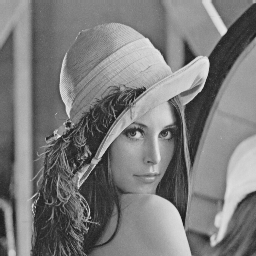

In [2]:
img = testimage("lena_gray")

In [3]:
typeof(img)

Array{ColorTypes.Gray{FixedPointNumbers.Normed{UInt8,8}},2}

In [4]:
img_as_array = convert(Array{Float32},img);

In [5]:
minimum(img_as_array), maximum(img_as_array)

(0.10196079f0, 0.9490197f0)

## HOG descriptor

- https://github.com/JuliaImages/ImageFeatures.jl/blob/master/docs/src/tutorials/object_detection.md

In [6]:
?(HOG)

search: HOG hough_circle_gradient hough_transform_standard morphogradient



```
hog_params = HOG([orientations = 9], [cell_size = 8], [block_size = 2], [block_stride = 1], [norm_method = "L2-norm"])
```

Histogram of Oriented Gradient (HOG) is a dense feature desciptor usually used for object detection. See "Histograms of Oriented Gradients for Human Detection" by Dalal and Triggs.

Parameters:  

  * orientations   = number of orientation bins
  * cell_size      = size of a cell is cell_size x cell_size (in pixels)
  * block_size     = size of a block is block_size x block_size (in terms of cells)
  * block_stride   = stride of blocks. Controls how much adjacent blocks overlap.
  * norm_method    = block normalization method. Options: L2-norm, L2-hys, L1-norm, L2-sqrt.


In [7]:
typeof(img)

Array{ColorTypes.Gray{FixedPointNumbers.Normed{UInt8,8}},2}

In [8]:
h = HOG(orientations=9,
        cell_size=8,
        block_size = 2,
        block_stride = 1,
        norm_method="L2-norm")

ImageFeatures.HOG(9, 8, 2, 1, "L2-norm")

In [9]:
@time hog_features = create_descriptor(img, HOG());

  4.662783 seconds (7.89 M allocations: 362.426 MiB, 2.60% gc time)


In [10]:
size(img), size(hog_features)

((256, 256), (34596,))

### Load pedestrian data

In [11]:
path_positive_examples = "/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians128x64/"
path_negative_examples = "/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians_neg/"
#path_positive_examples = "/home/david/Datasets/computer_vision/pedestrians/pedestrians128x64/"
#path_negative_examples = "/home/david/Datasets/computer_vision/pedestrians/pedestrians_neg/"

pos_example_names = readdir(path_positive_examples)
neg_example_names = readdir(path_negative_examples)
pos_images = []
neg_images = []

for n in pos_example_names
    push!(pos_images, load( path_positive_examples * n))
end

for n in neg_example_names
    push!(neg_images, load( path_negative_examples * n))
end

In [12]:
#path_positive_examples = "/home/david/Datasets/computer_vision/pedestrians/pedestrians128x64/"
#path_negative_examples = "/home/david/Datasets/computer_vision/pedestrians/pedestrians_neg/"
path_positive_examples = "/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians128x64/"
path_negative_examples = "/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians_neg/"

pos_example_names = readdir(path_positive_examples)
neg_example_names = readdir(path_negative_examples)

n_pos = length(pos_example_names)
n_neg = length(neg_example_names)

n = n_pos + n_neg                       # number of training examples 
data = Array{Float64}(3780, n)          # Array to store HOG descriptor of each image. Each image in our training data has size 128x64 and so has a 3780 length 
labels = Vector{Int64}(n);              # Vector to store label (1=human, 0=not human) of each image.

for (i, file) in enumerate([pos_example_names ; neg_example_names])
    
    #filename = "$(i <= n_pos ? path_positive_examples : path_negative_examples)/$file"
    if i <= n_pos
        filename =  path_positive_examples * file
    else
        filename = path_negative_examples * file
    end
    
    img = load(filename)   
    if i > n_pos # negative samples are bigger, we take a patch of the same shape
        img = img[1:128, 1:64]
    end
    
    data[:, i] = create_descriptor(img, HOG())
    labels[i] = (i <= n_pos ? 1 : 0)
end

In [13]:
println("size of the data:             ", size(data))
println("size of the labels:           ", size(labels))
println("number of negative labels:    ", sum(labels.==0))
println("number of positive labels:    ", sum(labels.==1))

size of the data:             (3780, 974)
size of the labels:           (974,)
number of negative labels:    50
number of positive labels:    924


## Negative samples are scarse

Notice the number of negative sample is very low, only 50.
We will augment the number of negative samples generating patches from the negative images.

In [14]:
sum(labels .==1), sum(labels.==0)

(924, 50)

In [15]:
size(neg_images[3]), size(pos_images[1])

((256, 256), (128, 64))

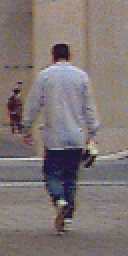

In [16]:
pos_images[1]

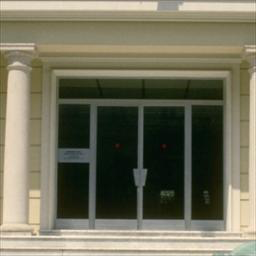

In [17]:
 neg_images[1]

### Generate negative samples of shape (128,64)

In [18]:
function extract_patches_2d(image, patch_size, stride)
    
    n_rows, n_cols = size(image) 
    n_rows_patch, n_cols_patch = patch_size
    patches = []
    for i in 1:stride:(n_rows - n_rows_patch)
        for j in 1:stride:(n_cols - n_cols_patch)
            push!(patches, image[i:i+n_rows_patch-1, j:j+n_cols_patch-1])
        end
    end
    
    return patches
end


extract_patches_2d (generic function with 1 method)

In [19]:
aux = extract_patches_2d(neg_images[1], (128,64), 10);

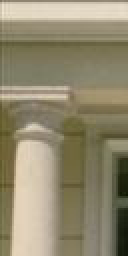

In [20]:
aux[1]

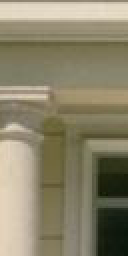

In [21]:
aux[2]

## Putting all the data together

In [66]:
#path_positive_examples = "/home/david/Datasets/computer_vision/pedestrians/pedestrians128x64/"
#path_negative_examples = "/home/david/Datasets/computer_vision/pedestrians/pedestrians_neg/"
path_positive_examples = "/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians128x64/"

pos_example_names = readdir(path_positive_examples)

n_pos = length(pos_example_names)
n_feat = 3780

data = Array{Float64}(n_feat, n_pos)  # Array to store HOG descriptor of each image. Each image in our training data has size 128x64 and so has a 3780 length 
labels = Vector{Int64}(n_pos);      # Vector to store label (1=human, 0=not human) of each image.

for (i, file) in enumerate(pos_example_names)
    filename =  path_positive_examples * file
    img = load(filename)   
    data[:, i] = create_descriptor(img, HOG())
    labels[i] = 1
end

In [67]:
path_negative_examples = "/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians_neg/"
neg_example_names = readdir(path_negative_examples);
size_patch = size(pos_images[1])
stride = 30
hog_descriptor = HOG()

begin
    for (i, file) in enumerate(neg_example_names)
        #print("Generating negative patches from: ", i, " out of ", length(neg_example_names), "\r")
        print("Generating negative patches from: ", i, "\r")
        
        filename =  path_negative_examples * file
        img = load(filename)   

        # For each negative images we extract several patches
        patches = extract_patches_2d(img, size_patch, stride);

        for patch in patches

            data = hcat(data, create_descriptor(patch, hog_descriptor))
            push!(labels,0);
        end
    end
end

In [68]:
size(data), size(labels)

((3780, 2674), (2674,))

In [69]:
println("Number of non pedestrian samples: ", sum(labels.==0))
println("Number of pedestrian samples:     ", sum(labels.==1))

Number of non pedestrian samples: 1750
Number of pedestrian samples:     924


### Train SVM

In [26]:
using LIBSVM

# Split the dataset into train and test set. Train set = 2500 images, Test set = 294 images.
srand(1234)
n_samples = size(data,2)
random_perm = randperm(n_samples)
first_80_percent = Int(round(n_samples*0.8))
train_ind   = random_perm[1:first_80_percent]
test_ind    = random_perm[first_80_percent:end]
#train_ind = 1:n

model = svmtrain(data[:, train_ind], labels[train_ind]; kernel=LIBSVM.Kernel.Linear);

In [27]:
model.nfeatures, model.nclasses, model.labels

(3780, 2, [1, 0])

In [28]:
# be careful about the size of the data!
# THIS WILL NOT WORK
# svmpredict(model, data[:,5])

In [29]:
descriptor =  data[:,2];
print(size(descriptor))

descriptor =  data[:,2:2];
print(size(descriptor))

(3780,)(3780, 1)

### Model evaluation train set

In [30]:
predicted_labels, _ = svmpredict(model,data);

In [31]:
sum(predicted_labels .== labels) / length(labels)

1.0

In [32]:
# this classier allways predicts no pedestrian (not very usefull..)
sum(predicted_labels .== 0), sum(predicted_labels .== 1)

(1750, 924)

### Testing the learned model

Since we have to predict over a window it would be nice to have a function that retrieves all wanted patches by the user. From there a feature vector is created and passed to the model.

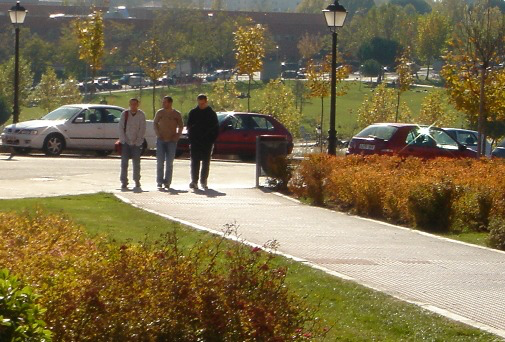

In [33]:
img = load("tutorial/humans.jpg")

In [34]:
rows, cols = size(img)

scores = []
descriptor = Array{Float64}(3780, 1)

# Apply classifier using a sliding window approach and store classification score for not-human 
# at every location in score array
stride = 10
n_row_patch, n_col_patch = size_patch
positions = Dict()
k = 0

@time begin
    for j in 1:stride:(cols - n_col_patch)
        for i in 1:stride:(rows - n_row_patch)
            patch = view(img, i:i+n_row_patch-1, j:j+n_col_patch-1)                  
            descriptor[:, 1]   = create_descriptor(patch, HOG())           
            predicted_label, s = svmpredict(model, descriptor);
            push!(scores,s[1])
            positions[k] = (i,j)
            k = k + 1    
        end
    end
end

  6.161532 seconds (100.27 M allocations: 13.732 GiB, 17.71% gc time)


This has two problems:

- The amount of allocations is unreasonable (13.7 GiB)
- Speed of svmpredict/create_descriptor 

In [35]:
@time svmpredict(model, descriptor);

  0.002184 seconds (20 allocations: 9.522 MiB)


In [36]:
@time create_descriptor( view(img, 1:1+n_row_patch-1, 1:1+n_col_patch-1), HOG());

  0.002943 seconds (101.30 k allocations: 4.674 MiB)


### Detect for all patches which contain pedestrain

In [37]:
pedestrians_detections = [pos for (pos,val) in enumerate(scores.>0.2) if val==true ];

In [38]:
pedestrians_detections

5-element Array{Int64,1}:
 228
 229
 295
 382
 383

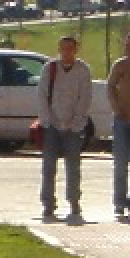

In [39]:
x,y = positions[pedestrians_detections[1]]
img[x:x+n_row_patch, y:y+n_col_patch]

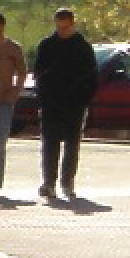

In [40]:
x,y = positions[pedestrians_detections[5]]
img[x:x+n_row_patch, y:y+n_col_patch]

### Mark a pedestrians with rectangles

Now we can simply go over each upper left coordinate where a pedestrian was found and plot a rectangle.

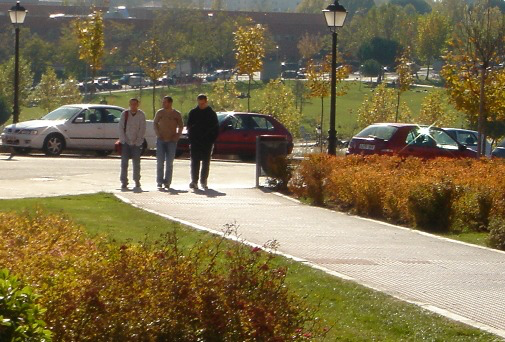

In [119]:
img = load("tutorial/humans.jpg")

In [120]:
c = ColorTypes.RGB{FixedPointNumbers.Normed{UInt8,8}}
for p in pedestrians_detections
    x,y = positions[p]
    img[x:x+n_row_patch,y] = c(1,0,0)                  # Left vertical bar
    img[x:x+n_row_patch,y+n_col_patch] = c(1,0,0)      # Right vertical bar
    img[x,y:y+n_col_patch] = c(1,0,0)                  # Top horizontal bar
    img[x+n_row_patch,y:y+n_col_patch] = c(1,0,0)      # Bottom horizontal bar
end

LoadError: [91mKeyError: key 295 not found[39m

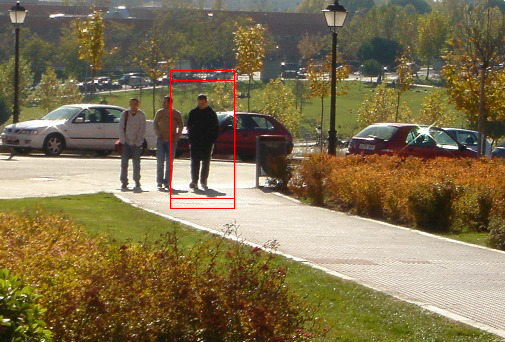

In [121]:
img

# Model with Perceptron

In [122]:
#Pkg.clone("https://github.com/davidbp/Perceptron.jl")

In [141]:
img = load("tutorial/humans.jpg")

using Perceptron
n_classes = 2
n_features = 3780
X_train = data[:, train_ind];
y_train = labels[train_ind] .+1;
percep = Perceptron.PerceptronClassifier(Float64, n_classes, n_features)

PerceptronClassifier{Float64}(n_classes=2, n_features=3780)

In [142]:
sum(y_train.==1), sum(y_train.==2)

(1411, 728)

In [143]:
scores = []
Perceptron.fit!(percep, X_train, y_train, n_epochs=100,  learning_rate=0.1, scores; print_flag=true)

In [175]:
@which Perceptron.predict(percep, descriptor)

predict(h::Perceptron.PerceptronClassifier, x::AbstractArray{T,1} where T) in Perceptron at /Users/davidbuchaca1/.julia/v0.6/Perceptron/src/Perceptron.jl:60

In [181]:
@time for i in 1:900 create_descriptor( view(img, 1:1+n_row_patch-1, 1:1+n_col_patch-1), HOG()); end

  3.020222 seconds (91.16 M allocations: 4.107 GiB, 21.68% gc time)


In [173]:
# We need to do the feature descriptors much more efficiently
# This proccess is allocating a huge amount of ram
@time begin
    for j in 1:stride:(cols - n_col_patch)
        for i in 1:stride:(rows - n_row_patch)
            patch = view(img, i:i+n_row_patch-1, j:j+n_col_patch-1)                  
            descriptor      = create_descriptor(patch, HOG())           
        end
    end
end

  3.348075 seconds (100.02 M allocations: 4.514 GiB, 21.49% gc time)


In [174]:
rows, cols = size(img)
y_scores = []
y_hats = []
descriptor = Array{Float64}(3780)



# Apply classifier using a sliding window approach and store classification score for not-human 
# at every location in score array
stride = 10
n_row_patch, n_col_patch = size_patch
positions = Dict()
k = 0

@time begin
    for j in 1:stride:(cols - n_col_patch)
        for i in 1:stride:(rows - n_row_patch)
            patch = view(img, i:i+n_row_patch-1, j:j+n_col_patch-1)                  
            descriptor      = create_descriptor(patch, HOG())           
            y_hat, y_score  = Perceptron.predict(percep, descriptor);
            
            push!(y_scores, y_score)
            push!(y_hats, y_hat)
            positions[k] = (i,j)
            k = k + 1
        end
    end
end

  3.407043 seconds (100.05 M allocations: 4.516 GiB, 21.61% gc time)


In [150]:
sum(scores), length(scores)

(99.92286115007013, 100)

In [151]:
sum(labels), length(labels)

(924, 2674)

In [152]:
sum(map(indmax,y_scores).==1), sum(map(indmax,y_scores).==2)

(982, 8)

In [153]:
pos = []
for (i,s) in enumerate(y_scores)
    if indmax(s).==2
        push!(pos, i)
    end
end

In [154]:
pos

8-element Array{Any,1}:
 207
 229
 295
 317
 381
 382
 383
 384

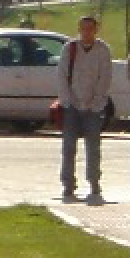

In [155]:
x,y = positions[pos[1]]
img[x:x+n_row_patch, y:y+n_col_patch]

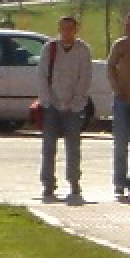

In [156]:
x,y = positions[pos[2]]
img[x:x+n_row_patch, y:y+n_col_patch]

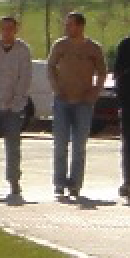

In [157]:
x,y = positions[pos[3]]
img[x:x+n_row_patch, y:y+n_col_patch]

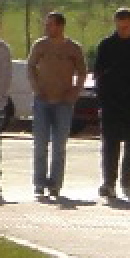

In [158]:
x,y = positions[pos[4]]
img[x:x+n_row_patch, y:y+n_col_patch]

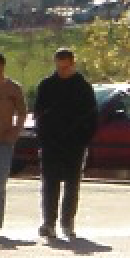

In [159]:
x,y = positions[pos[5]]
img[x:x+n_row_patch, y:y+n_col_patch]

In [160]:
pedestrians_detections_perceptron = pos

8-element Array{Any,1}:
 207
 229
 295
 317
 381
 382
 383
 384

In [161]:
c = ColorTypes.RGB{FixedPointNumbers.Normed{UInt8,8}}
for p in pedestrians_detections
    x,y = positions[p]
    img[x:x+n_row_patch,y] = c(1,0,0)                  # Left vertical bar
    img[x:x+n_row_patch,y+n_col_patch] = c(1,0,0)      # Right vertical bar
    img[x,y:y+n_col_patch] = c(1,0,0)                  # Top horizontal bar
    img[x+n_row_patch,y:y+n_col_patch] = c(1,0,0)      # Bottom horizontal bar
end

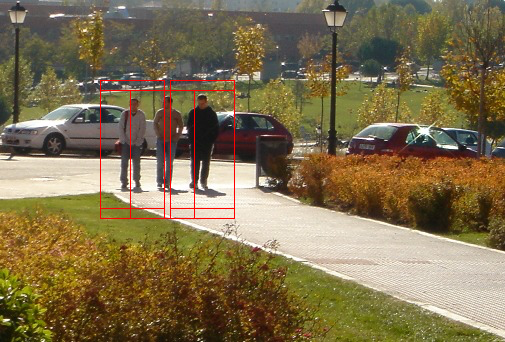

In [162]:
img

## Improving the process with less allocations

We need to make each feature vector faster and generating less allocations.


In [182]:
@time for i in 1:900 
    create_descriptor( view(img, 1:1+n_row_patch-1, 1:1+n_col_patch-1), HOG()); 
end

  3.005355 seconds (91.16 M allocations: 4.107 GiB, 21.65% gc time)
